# Practical work 4: Frequency filtering, color

In [1]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift
import matplotlib.pyplot as plt
from PIL import Image

def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()


## Exercice 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of `img/mandrill.png` (use functions seen in previous lessons). 

In [2]:
def computeFT(I):
    """ Array -> Array[complex] """
    return fft2(I)

def toVisualizeFT(If):
    """ Array[complex] -> Array[float] """
    return fftshift(np.abs(If))

def toVisualizeLogFT(If):
    """ Array[complex] -> Array[float] """
    return fftshift(np.log(1+np.abs(If)))

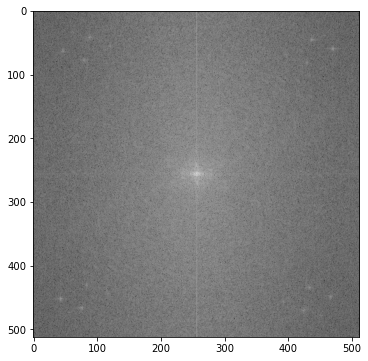

In [3]:
mandrill = np.array(Image.open('img/mandrill.png'))

imshow(toVisualizeLogFT(computeFT(mandrill)))

2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at Euclidian distance $f_c$ from the center (null frequency).

ILPF = np.zeros((n, m))
    sig = 1/fc
    
    for i in range(-m//2+1, m//2+1):
        for j in range(-n//2+1, n//2+1):
            ILPF[i+m//2, j+n//2] = np.exp(-(i**2 + j**2)/(2*sig))/(2*np.pi*sig**2)
            
    return ILPF

In [4]:
def idealLowPassFilter(n, m, fc):
    
    ILPF = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            if (np.sqrt((i-n//2)**2 + (j-m//2)**2) <= fc):
                ILPF[i, j] = 1
            
    return ILPF

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (use function `ifft2()` from module `numpy.fft`)
 - return the real part of filtered image

In [5]:
from numpy.fft import ifftshift

def lowPass(I, fc):
    fourierTransformedImage = fftshift(computeFT(I))
    idealFilter = idealLowPassFilter(I.shape[0], I.shape[1], fc)
    filteredSpect = fourierTransformedImage * idealFilter
    filteredImage = ifft2(ifftshift(filteredSpect))
    return np.real(filteredImage)
    

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


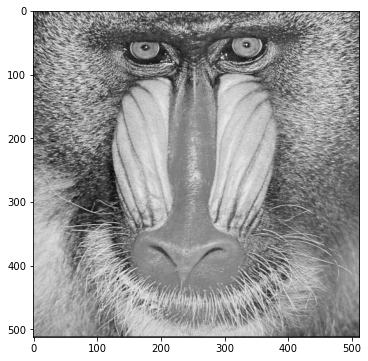

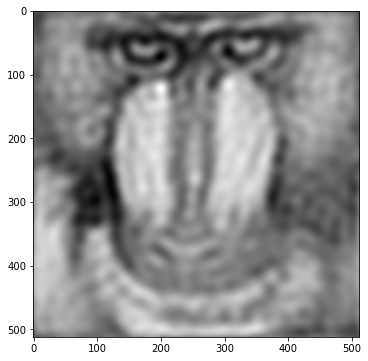

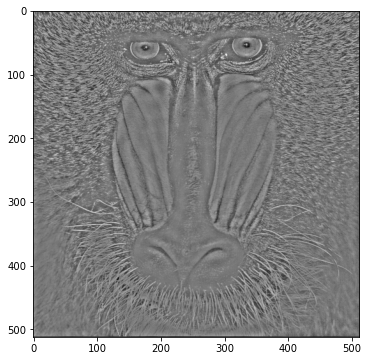

In [6]:
imshow(mandrill)
imshow(lowPass(mandrill, 20))
imshow(mandrill - lowPass(mandrill, 20))

#on voit l'image de plus en plus floue

#passe bas laisse passer les hautes freq on le voit en soustraction qui fait apparaitre les contours = haute freq

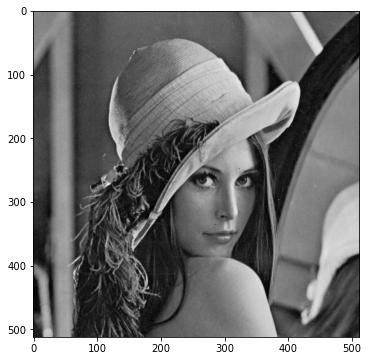

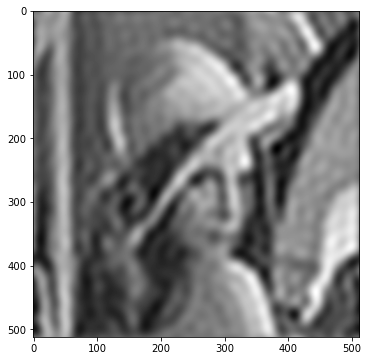

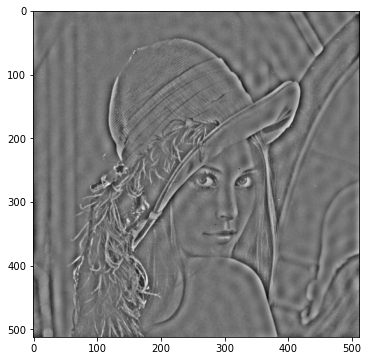

In [7]:
lena = np.array(Image.open('img/lena.jpg'))
imshow(lena)
imshow(lowPass(lena, 20))
imshow(lena - lowPass(lena, 20))

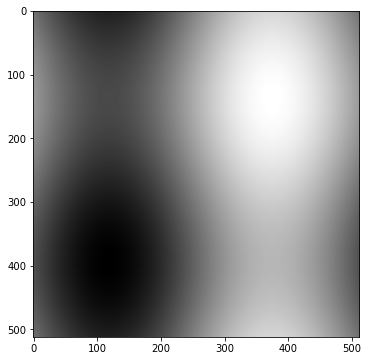

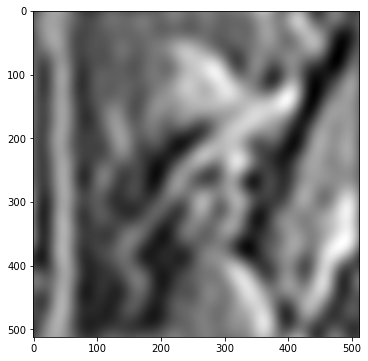

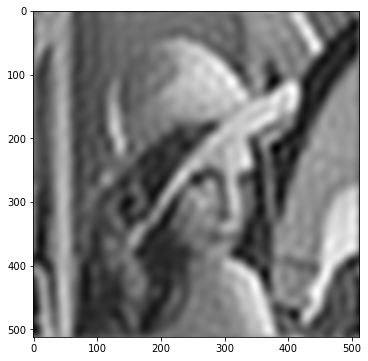

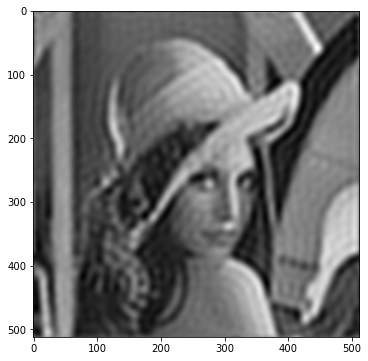

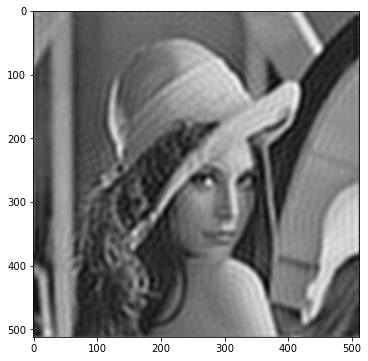

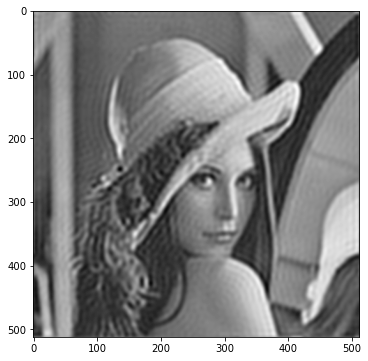

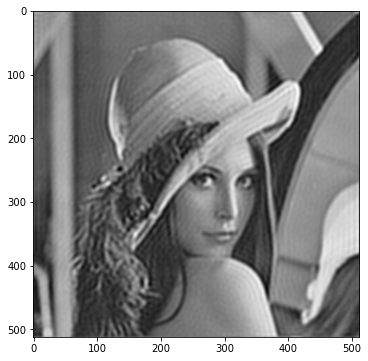

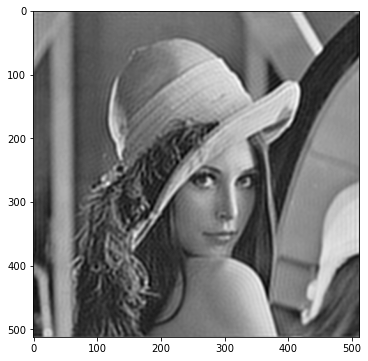

In [8]:
for fc in range(1, 80, 10):
    imshow(lowPass(lena, fc))

## Exercice 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

Il faut ajouter (d-1)/2 lignes et colonnes de part et d'autre de l'image étudiée. Le cas extreme etant l'étude d'un des quatre coins de l'image.

2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1. It is not allowed to use a module implementing the padding.

In [9]:
def imagePad(I,h):
    add = (h.shape[0]-1)//2
    nI = np.zeros((I.shape[0]+2*add, I.shape[1]+2*add))
    nI[add:I.shape[0]+add, add:I.shape[1]+add] = I
    return nI

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [10]:
def conv2(I,h):
    nI = I.copy()
    paddedImg = imagePad(nI, h)
    
    xI,yI = nI.shape
    xh,yh = h.shape
    
    
    for n in range(xI):
        for m in range(yI):
            val = 0
            for i in range(xh):
                for j in range(yh):
                    val += paddedImg[n+i, m+j]*h[i,j]
            nI[n,m] = val
    return nI

In [11]:
def meanFilter(size):
    return np.ones((size,size))/(size**2)

4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

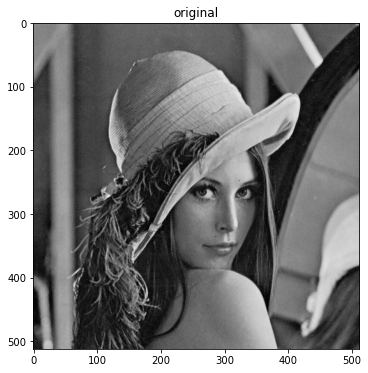

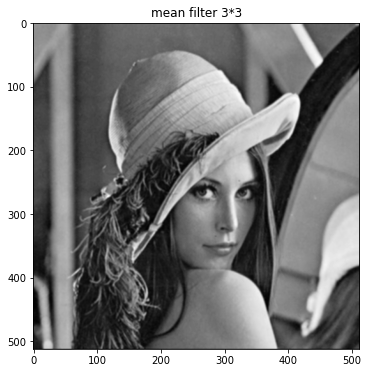

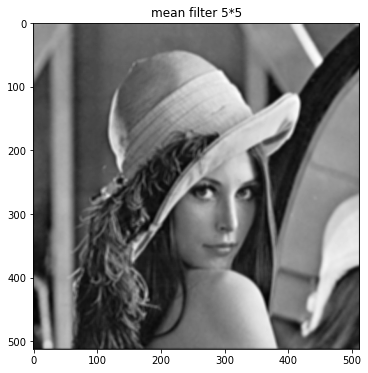

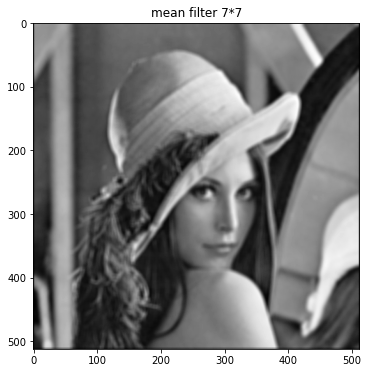

In [12]:
imshow(lena, "original")
imshow(conv2(lena, meanFilter(3)), "mean filter 3*3")
imshow(conv2(lena, meanFilter(5)), "mean filter 5*5")
imshow(conv2(lena, meanFilter(7)), "mean filter 7*7")

5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

6. Interpretation: what is the analytic expression of the transfert function of a mean filter? Is  it an ideal low pass filter?

7. Bonus question: perform the same study for the Gaussian kernel. Determine $\sigma$ in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

In [13]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()
### your answer start below


## Exercice 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

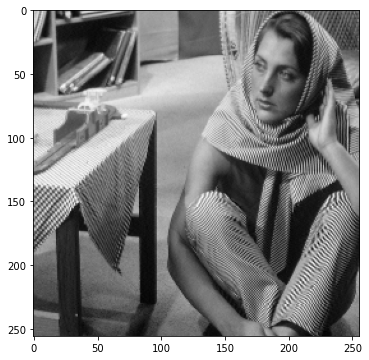

In [24]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

barbara = np.array(Image.open('img/barbara.png'))
SS2Barbara = subSample2(barbara)
imshow(SS2Barbara)

2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

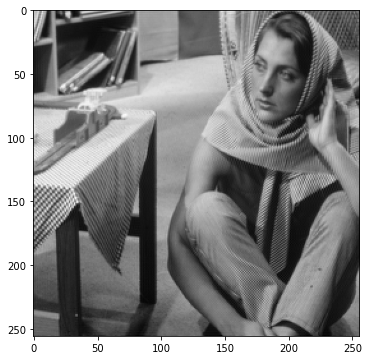

In [28]:
def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A
### your answer start below
AAFBarbaraSpect = fftshift(computeFT(barbara)) * antiAliasingFilter(barbara.shape[0], barbara.shape[1])
ReconstructedBarbara = np.real(ifft2(ifftshift(AAFBarbaraSpect)))
AAFSS2Barbara = subSample2(ReconstructedBarbara)
imshow(AAFSS2Barbara)

In [ ]:
# La fonction antiAliasingFilter donne un filtre de même taille que l'image (512x512), 
# donc il faut revoir la fonction conv2 je pense, elle est trop lente (au bout 5min toujours pas fini).
# Aussi, le filtre a une taille paire, donc il n'y a pas de centre !

subSampledImg = subSample2(barbara)
# imshow(subSampledImg)
imshow(conv2(subSampledImg, antiAliasingFilter(subSampledImg.shape[0], subSampledImg.shape[1])))

# for i in range(10):
#     filteredBarbara = conv2(barbara, antiAliasingFilter(barbara.shape[0], barbara.shape[1]))
#     subSampledImage = subSample2(filteredBarbara, 2**i)
#     imshow(subSampledImage, 'image barbara filtrée et sous-échantillonée de facteur %d' % 2**i)

3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

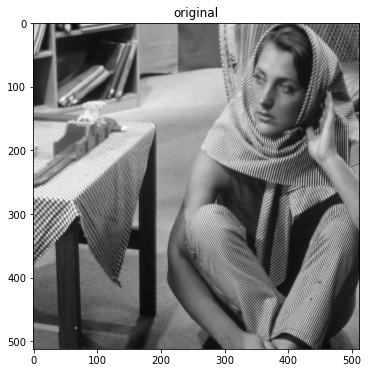

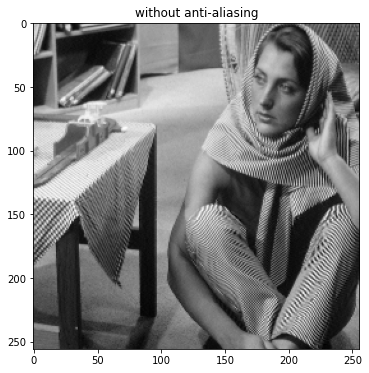

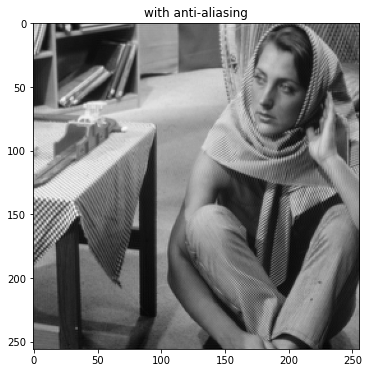

In [29]:
imshow(barbara, "original")
imshow(SS2Barbara, "without anti-aliasing")
imshow(AAFSS2Barbara, "with anti-aliasing")

## Exercice 4: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images examine their shape. What difference there are between them?

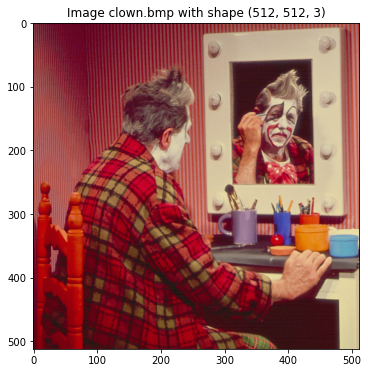

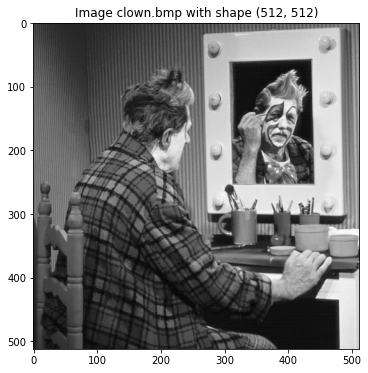

In [33]:
I1 = np.array(Image.open('img/clown.bmp'))
I2 = np.array(Image.open('img/clown_lumi.bmp'))

# Image I1 a une dimension en plus
imshow(I1, 'Image clown.bmp with shape ' + str(I1.shape))
imshow(I2, 'Image clown.bmp with shape ' + str(I2.shape))

# I2 est une 2Darray (image en noir et blanc) alors que I1 est une 3Darray de taille 3 pour la 
# 3ieme dimension, ceci correspond au système de représentation des couleurs RVB dans ce cas
# correspondant à une array de taille 3 avec des valeurs entre 0 et 255 pour rouge, vert et bleu

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

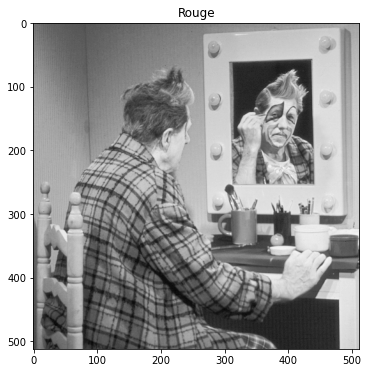

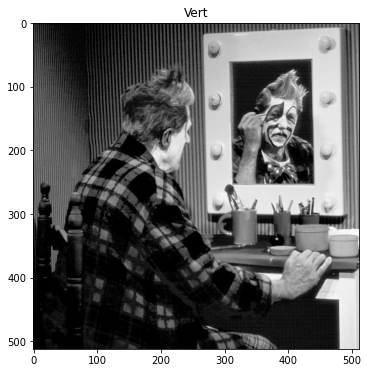

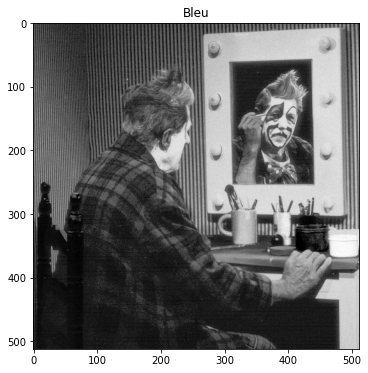

In [35]:
# I1 possède 3 dimensions, les deux premières représentent la position de chaque pixel de l'image,
# et la dernière dimension de taille 3 exprime l'intensite des couleurs RVB (rouge - vert - bleu) 
# respectivement du pixel (exemple I1[0, 0] affiche la valeur RVB du pixel dans le coin en haut 
# à gauche de l'image)
IR = I1[:,:,0]
IG = I1[:,:,1]
IB = I1[:,:,2]

imshow(IR, 'Rouge')
imshow(IG, 'Vert')
imshow(IB, 'Bleu')
# On peut observer à travers ces trois images que, IR est beaucoup plus claire que les deux autres,
# et c'est tout à fait ce qu'on doit attendre, puisque l'image d'origine est composée principalement
# de la couleur rouge, ainsi, la valeur de R devrait être plus importante dans la plupart des pixels =>
# la valeur R plus proche de 255 et les V, B plus proche de 0.
# c'est pourquoi IR est plus claire aue les deux autres.

3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

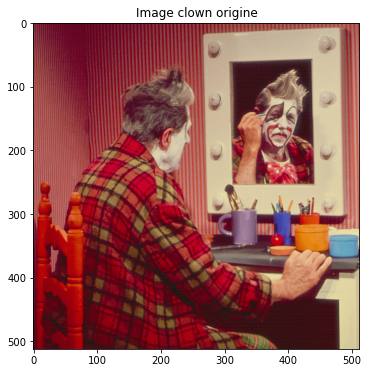

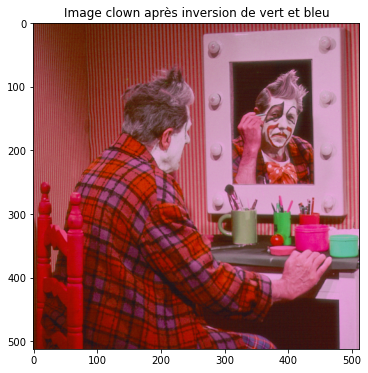

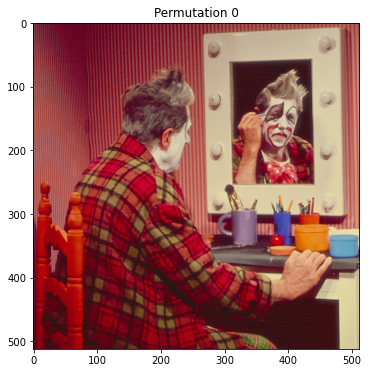

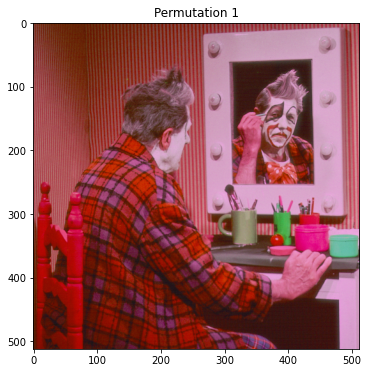

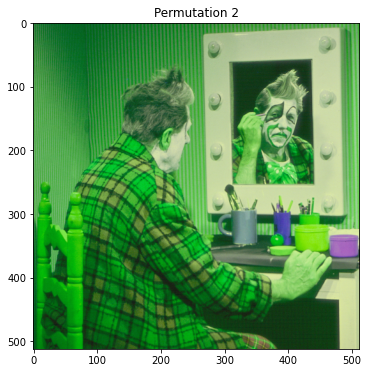

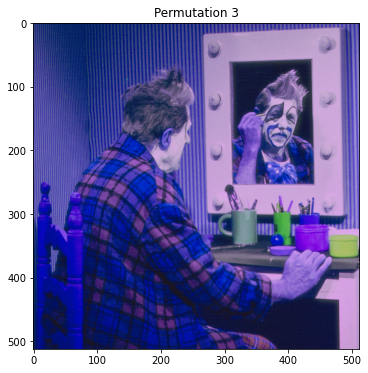

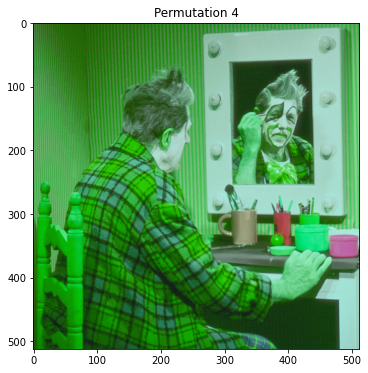

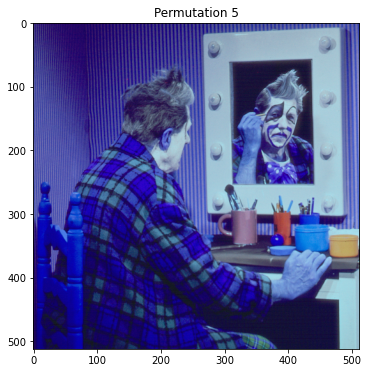

In [41]:
import itertools

I3 = np.dstack((IR, IB, IG))
imshow(I1, 'Image clown origine')
imshow(I3, 'Image clown après inversion de vert et bleu')

# Génération de toutes les combinaisons possibles
permutations = list(itertools.permutations([IR, IG, IB]))
for i in range(len(permutations)):
    imshow(np.dstack(permutations[i]), "Permutation " + str(i))
    

4. Write a code that allows the see the first channel with red color scales, the second channel in green color scales, and the blue channel in blue color scales.

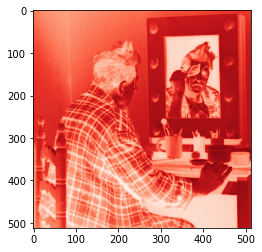

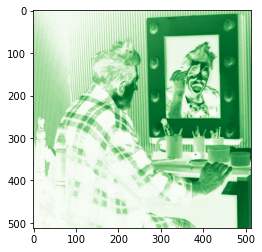

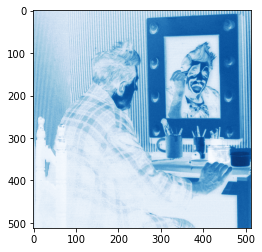

In [49]:
plt.imshow(IR, cmap = "Reds")
plt.show()

plt.imshow(IG, cmap = "Greens")
plt.show()

plt.imshow(IB, cmap = "Blues")
plt.show()